<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Much of this material was either adapted from course notes by [C. Bretherton](http://www.atmos.washington.edu/~breth/) or Nick Trefethen's book entitled ["Spectral Methods in MATLAB"](http://bookstore.siam.org/se10/).

In [1]:
%matplotlib inline
import numpy
import numpy.fft as fft
import matplotlib.pyplot as plt

# Spectral Methods

## Discrete Fourier Transform

Let $y_n$ with $n=1, \ldots, N$ be a sequence of $N$ possibly complex values.  The *discrete Fourier transform* (DFT) of this sequence is the sequence $Y_m$ with $m=1,\ldots, N$ where
$$
    Y_m = \sum^N_{n=1} y_n e^{-2 \pi i(m - 1)(n - 1) / N}
$$
and with the inverse transform
$$
    y_n = \frac{1}{N} \sum^N_{m=1} Y_m e^{2 \pi i (m - 1) (n - 1) / N}.
$$
The uses of the DFT ranges from highly (spectrally) accurate numerical differentiation to time series analysis, filtering, and quadrature.  

Direct use of these formulas would require $\mathcal{O}(N^2)$ operations to perform a transform.  If however $N = 2^k$ for some $k \in \mathbb{Z^+}$ one of the wonders of modern computing, the fast Fourier transform (FFT) can be used requiring $\mathcal{O}(N \log N)$ operations instead.  This can be generalized (by dividing the domain into the appropriate number of points) without general loss of speed.  Due to the ubiquity of the FFT most people will use FFT in place of the DFT when describing approaches.

### Relation to Fourier Analysis

One perspective we can take to formulate spectral methods is one where we want to reconstruct/deconstruct periodic functions $y(x)$ of some wave-length $L$, based on its values at the discrete set of $N$ equally spaced points
$$
    x_n = (n-1) L / N.
$$

Consider the Fourier coefficients of our function $y(x)$,
$$
    \hat{y}_M = \frac{1}{L} \int^L_0 y(x) \exp(-i k(M) x) dx, ~~~ M = 0, \pm 1, \pm 2, \ldots
$$
where the wave number associated with the Fourier coefficient $M$ is
$$
    k(M) = \frac{2 \pi M}{L}.
$$
From these coefficients we can reconstruct the function $y(x)$ as
$$
    y(x) = \sum^\infty_{M=-\infty} \hat{y}_M \exp(i k(M) x).
$$

Recall that we know that the coefficients $\hat{y}_M \rightarrow 0$ as $M \rightarrow \infty$.  In particular if $y(x) \in C^R$ over the entire interval $[0, L]$ then the Fourier coefficients decay as $\mathcal{O}(|M|^{-(R + 1)})$.

To connect the DFT coefficients $Y_m$ and the Fourier coefficients $\hat{y}_m$ we can approximate the integral above via a Riemann sum to find
$$\begin{aligned}
    \hat{y}_M &\approx \frac{1}{L} \sum^N_{n=1} y(x_n) \exp(-i k(M) x_n) \Delta x\\
    &= \frac{1}{N} \sum^N_{n=1} y(x_n) \exp(-i [2 \pi M / L] [(n - 1) L / N]) \\
    &= Y_m / N
\end{aligned}$$
where
$$
    m = \mod(M, N) + 1, ~~~ 1 \leq m \leq N.
$$

Now to fully reconstruct the approximation we take $m=1,2,\ldots,N$ and a sequence of wave numbers 
$$
    M_m = 0, 1, 2, \ldots, N / 2 - 1, - N / 2, \ldots, -1,
$$
and a corresponding sequence of wavenumbers $k_m = k(M_m) = 2 \pi M_m / L$ to find
$$\begin{aligned}
    \hat{y}_M &\approx \frac{Y_m}{N} \\
    y(x) &\approx y_N(x) = \sum^{N/2 - 1}_{M=-N/2} \frac{Y_m}{N} \exp(i k(M) x) = \sum^{N}_{m=1} \frac{Y_m}{N} \exp(i k_m x)
\end{aligned}$$

For the examples below observe how fast the coefficients of the FFT fall off for various types of functions.
1. Square wave, $C^0$ with coefficients falling off as $\mathcal{O}(|M|^{-1})$. Exact $\hat{y}_M = -2 i / (\pi M), M$ odd.
1. Saw tooth wave, $C^1$ with coefficients falling off as $\mathcal{O}(|M|^{-2})$. Exact $\hat{y}_M = 2 / (\pi M)^2, M$ odd.
1. Function $(1-0.6 \cos(2 \pi x / L))^{-1}$, $C^\infty$ with coefficients falling off *spectrally* (beyond any algebraic order).  Exact $\hat{y}_M = 1.25 \cdot 3^{-|M|}$.

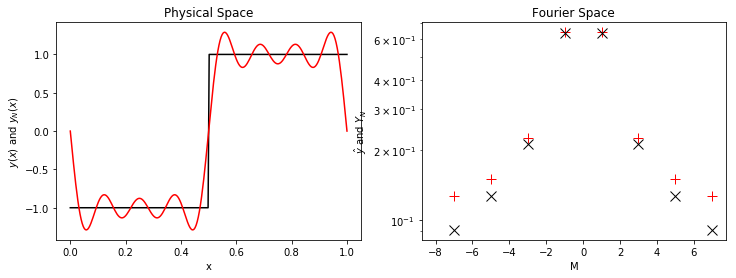

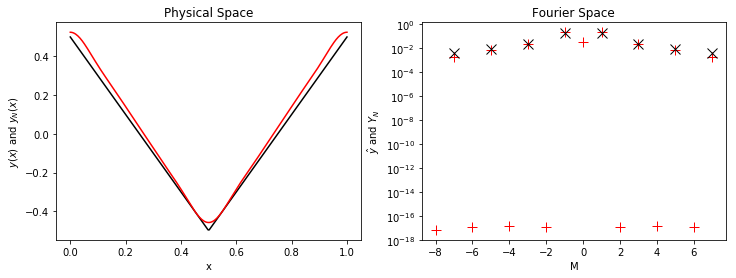

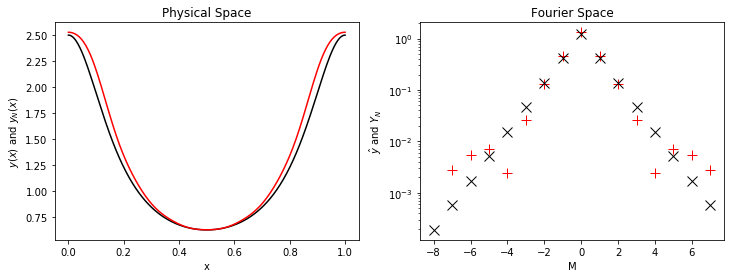

In [2]:
L = 1.0
N = 2**4
x = numpy.linspace(0.0, L, N)
delta_x = L / N
x_fine = numpy.linspace(0.0, L, 2**8)
M = fft.fftfreq(N, 1.0 / N)
M_odd = M[numpy.nonzero(numpy.ravel(numpy.mod(M, 2)))]
k = 2.0 * numpy.pi * M / L

y = [lambda x: numpy.sign(x - 0.5),
     lambda x: numpy.abs(2.0 * x - 1.0) - 0.5,
     lambda x: 1.0 / (1.0 - 0.6 * numpy.cos(2.0 * numpy.pi / L * x))]
y_hat = [lambda M:-2.0j / (numpy.pi * M),
         lambda M:2.0 / (numpy.pi * M)**2,
         lambda M:1.25 * 3.0**(-numpy.abs(M))]
    
for (i, y) in enumerate(y):
    Y = fft.fft(y(x))
    y_inv = numpy.zeros(x_fine.shape[0])
    for m in xrange(N):
        y_inv += ((Y[m] / N) * numpy.exp(1.0j * k[m] * (x_fine - 1.0 / (2.0 * N)))).real

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth() * 2)
    axes = fig.add_subplot(1, 2, 1)
    axes.plot(x_fine, y(x_fine), 'k')
    axes.plot(x_fine, y_inv,'r')
    axes.set_xlabel("x")
    axes.set_ylabel("$y(x)$ and $y_N(x)$")
    axes.set_title("Physical Space")

    axes = fig.add_subplot(1, 2, 2)
    axes.semilogy(M, numpy.abs(Y) / N, '+r', markersize=10)
    if i != 2:
        axes.semilogy(M_odd, numpy.abs(y_hat[i](M_odd)) , 'xk', markersize=10)
    else:
        axes.semilogy(M, numpy.abs((y_hat[i](M))), 'xk', markersize=10)
    axes.set_xlabel("M")
    axes.set_ylabel("$\hat{y}$ and $Y_N$")
    axes.set_title("Fourier Space")

plt.show()

Practically speaking then we can say that the smoother the function the fewer Fourier coefficients we need to have hanging around in order for us to approximate the functions $y(x)$.

### Properties of the DFT

Let $\mathbf{y}$ be a vector of gridpoint values $y_i$, the the DFT and inverse DFT can be written as matrix operators
$$
    \mathbf{Y} = DFT(\mathbf{y}) = N^{1/2} \mathbf{F} \mathbf{y} \\
    \mathbf{y} = DFT^{-1}(\mathbf{Y}) = N^{1/2} \mathbf{F}^\ast \mathbf{Y}.
$$
Here $\mathbf{Y}$ is the DFT of $\mathbf{y}$,
$$
    F_{mn} = N^{-1/2} \exp(-2 \pi i (m - 1)(n - 1)),
$$
and $\mathbf{F}^\ast$ is the conjugate transpose of $\mathbf{F}$.

From this we can also derive *Parseval's identity* for the discrete transform
$$\begin{aligned}
    \sum^N_{m=1} \frac{|Y^2_m|}{N} &= \frac{\mathbf{Y}^\ast \mathbf{Y}}{N} \\
    &= \mathbf{y}^\ast \mathbf{F}^\ast \mathbf{F} \mathbf{y} \\
    &= \mathbf{y}^\ast \mathbf{y} \\
    &= \sum^N_{n=1} |y^2_n|
\end{aligned}$$
using the fact that $\mathbf{F}$ is a unitary matrix (i.e. $\mathbf{F}^\ast \mathbf{F} = \mathbf{F} \mathbf{F}^\ast = \mathbf{I}$).

The DFT also obeys the convolution theorem so that
$$
    DFT(w \ast y) = W_m Y_m
$$
where
$$
    (w \ast y)_n = \sum^N_{p=1} w_p y_{n-p}
$$
is the convolution of $w$ and $y$.

**Theorem** Smoothness of a function and decay of its Fourier coefficients.

Let $u \in L^2(\mathbb R)$ have a Fourier transform $\hat{u}$, then
1. If $u$ has $p-1$ continuous derivatives in $L^2(\mathbb R)$ for some $p \geq 0$ and a $p$th derivative of bounded variation then
$$
    \hat{u}(k) = \mathcal{O}(|k|^{-p-1} ) ~~~~ \text{as} ~~~~ |k| \rightarrow \infty.
$$
1. If $u$ has infinitely many continuous derivatives in $L^2(\mathbb R)$ then
$$
    \hat{u}(k) = \mathcal{O}(|k|^{-m} ) ~~~~ \text{as} ~~~~ |k| \rightarrow \infty
$$
for every $m \geq 0$, this is also known as *spectral* convergence.  The converse also holds.
1. If there exists a $a, c > 0$ such that $u$ can be extended to an analytic function in the complex strip $|\Im(z)| < a$ with $\| u(\cdot + i y) \| \leq c$ uniformly for all $y \in (-a, a)$, where $\| u(\cdot + i y) \|$ is the $L^2$ norm along the horizontal line $\Im(z) = y$, then $u_a(k) \in L^2(\mathbb R)$, where $u_a(k) = e^{a |k|} \hat{u}(k)$.  The converse also holds.
1. If $u$ can be extended to an entire function (i.e. analytic throughout the complex plane) and there exists $a > 0$ such that $|u(z)| = \mathcal{O}(e^{a|z|})$ as $z \rightarrow \infty$ for all complex values $z \in \mathbb C$ then $\hat{u}$ has compact support contained in $[-a, a]$.  The converse also holds

### Differentiation

Recall that the Fourier transform of a derivative turns the derivative into an algebraic expression:
$$
    \hat{u_x} = i \xi \hat{u}.
$$
We can exploit this in the discrete case as well.

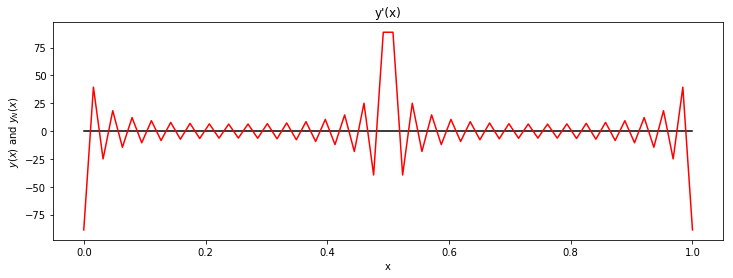

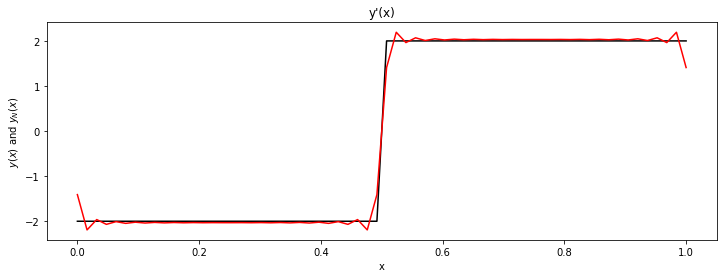

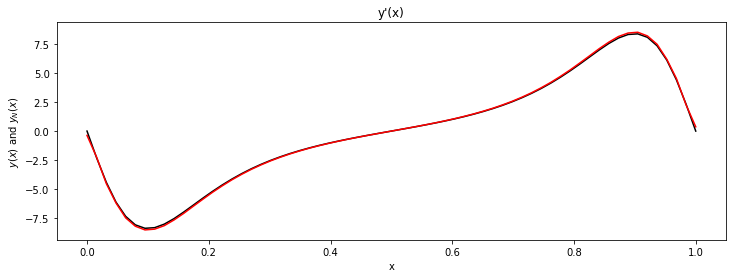

In [3]:
L = 1.0
N = 2**6
x = numpy.linspace(0.0, L, N)
M = fft.fftfreq(N, 1.0 / N)
M_odd = M[numpy.nonzero(numpy.ravel(numpy.mod(M, 2)))]
k = 2.0 * numpy.pi * M / L

y_funcs = [lambda x: numpy.sign(x - 0.5),
           lambda x: numpy.abs(2.0 * x - 1.0) - 0.5,
           lambda x: 1.0 / (1.0 - 0.6 * numpy.cos(2.0 * numpy.pi / L * x))]
y_prime_funcs = [lambda x: numpy.zeros(x.shape[0]),
                 lambda x: 2.0 * numpy.sign(x - 0.5),
                 lambda x: -1.2 * numpy.pi / L * numpy.sin(2.0 * numpy.pi / L * x) / (1.0 - 0.6 * numpy.cos(2.0 * numpy.pi / L * x))**2]

for (i, y) in enumerate(y_funcs):
    Y = fft.fft(y(x))
    y_prime = fft.ifft(1.0j * k * Y).real

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth() * 2)
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x, y_prime_funcs[i](x), 'k')
    axes.plot(x, y_prime,'r')
    axes.set_xlabel("x")
    axes.set_ylabel("$y(x)$ and $y_N(x)$")
    axes.set_title("y'(x)")

plt.show()

We can also write this operation as a matrix operation (assuming a periodic function):
$$\begin{aligned}
    y'(x) \approx N^{-1/2} \mathbf{F}^\ast i \mathbf{K} \mathbf{Y} = N^{-1/2} \mathbf{F}^\ast i \mathbf{K} N^{1/2} \mathbf{F} \mathbf{y} = \mathbf{D} \mathbf{y}
\end{aligned}$$
where $D \equiv \mathbf{F}^\ast (i \mathbf{K}) \mathbf{F}$ is the *Fourier pseudospectral differentiation matrix*.  It is real, dense, anti-symmetric, and $N \times N$.  The matrix $\mathbf{K} \equiv diag(\mathbf{k})$.

Also, due to $\mathbf{F}$ being unitary, we can compose multiple derivatives by simply applying the matrix multiple time to find the $p$th derivative.
$$
    D^p = (\mathbf{F}^\ast i \mathbf{K} \mathbf{F})^p = \mathbf{F}^\ast (i \mathbf{K})^p \mathbf{F}
$$

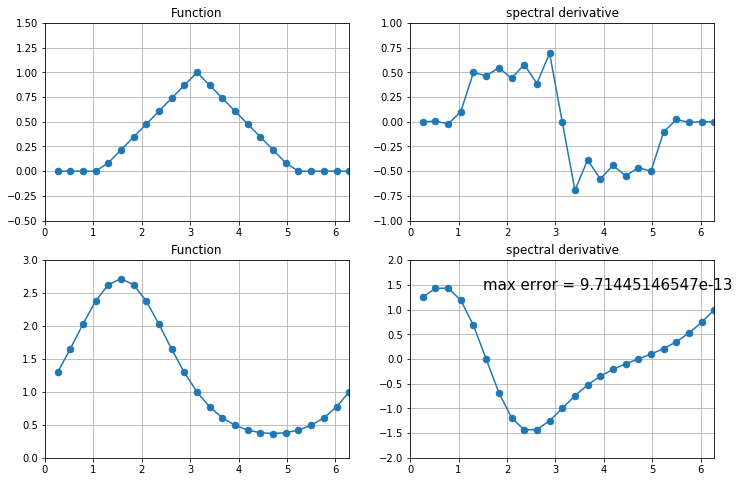

In [4]:
# Example Program 4 from Trefethen - Spectral Methods in MATLAB

import scipy.linalg as linalg

N = 24
delta_x = 2.0 * numpy.pi / N
x = numpy.linspace(delta_x, delta_x * N, N)

# Use differentiation matrix to perform derivatives
column = numpy.empty(N)
column[1:] = 0.5*(-1.0)**(numpy.arange(1, N)) * 1.0 / numpy.tan(numpy.arange(1, N) * delta_x / 2.0)
column[0] = 0.0
index_array = numpy.empty(N, dtype=int)
index_array[0] = 0
index_array[1:] = numpy.flipud(numpy.arange(1, N))
D = linalg.toeplitz(column, column[index_array])

fig, axes = plt.subplots(2, 2)
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)

# Differentiation of a hat function
v = numpy.where(1 - numpy.abs(x - numpy.pi) / 2.0 > 0.0, 1 - numpy.abs(x - numpy.pi) / 2.0, 0.0)
axes[0, 0].plot(x, v, '.-', markersize=13)
axes[0, 0].set_xlim((0, 2 * numpy.pi))
axes[0, 0].set_ylim((-0.5, 1.5))
axes[0, 0].set_title("Function")
axes[0, 0].grid(True)

axes[0, 1].plot(x, numpy.dot(D, v), '.-', markersize=13)
axes[0, 1].set_xlim((0, 2*numpy.pi))
axes[0, 1].set_ylim((-1, 1))
axes[0, 1].set_title('spectral derivative')
axes[0, 1].grid(True)

# Differentiation of exp(sin(x))
v = numpy.exp(numpy.sin(x))
v_prime = numpy.cos(x) * v
axes[1, 0].plot(x, v, '.-', markersize=13)
axes[1, 0].set_xlim((0, 2 * numpy.pi))
axes[1, 0].set_ylim((0.0, 3.0))
axes[1, 0].set_title("Function")
axes[1, 0].grid(True)

axes[1, 1].plot(x, numpy.dot(D, v), '.-', markersize=13)
axes[1, 1].set_xlim((0, 2*numpy.pi))
axes[1, 1].set_ylim((-2, 2))
axes[1, 1].set_title('spectral derivative')
axes[1, 1].grid(True)
error = numpy.linalg.norm(numpy.dot(D, v) - v_prime, ord=numpy.infty)
axes[1, 1].text(1.5, 1.4, "max error = %s" % error, fontsize=15)

plt.show()

### Spectral Methods

We can also apply the approach above if periodic boundary conditions are used and smooth solutions are expected.  Let's examine this via an example.

We want to solve the avection equation with a variable speed
$$
    u_t + c(x) u_x = 0, ~~~~ \Omega = [0, 2 \pi]
$$
with periodic boundary conditions with the initial condition
$$
    u(x,0) = \exp(-100 (x - 1)^2)
$$
and variable speed
$$
    c(x) = 1/5 + \sin^2(x - 1)
$$

Now let's construct a method based on leapfrog and the differentiation approach above.  Note that in the method of lines perspective we would have
$$
    \frac{U^{n+1}_j - U^{n+1}_j}{2 \Delta t} = f(U^n) = -c(x_j) (D U^n)_j
$$
where here we have used instead of a centered difference the differentiation matrix above.  We can also use the (more efficient) method based on knowing the Fourier transform of the derivative.  Note that we are using an approximation here to bootstrap the method.

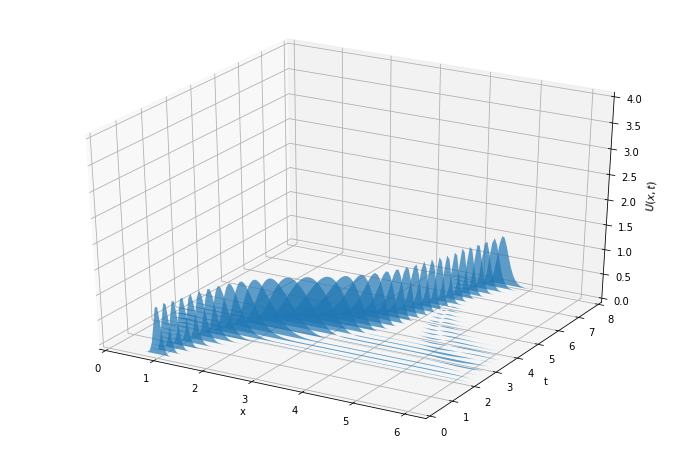

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.collections
import matplotlib.colors

# Compare a pseudo-spectral approach to a finite difference approach
# to the variable coefficient advection problem posed above

# Construct domain
N = 128
L = 2.0 * numpy.pi
delta_x = L / N
delta_t = delta_x / 4.0
x = numpy.linspace(delta_x, delta_x * N, N)
M = fft.fftfreq(N, 1.0 / N)
k = 2.0 * numpy.pi * M / L
c = 0.2 + numpy.sin(x - 1.0)**2

column = numpy.empty(N)
column[1:] = 0.5*(-1.0)**(numpy.arange(1, N)) * 1.0 / numpy.tan(numpy.arange(1, N) * delta_x / 2.0)
column[0] = 0.0
index_array = numpy.empty(N, dtype=int)
index_array[0] = 0
index_array[1:] = numpy.flipud(numpy.arange(1, N))
D = linalg.toeplitz(column, column[index_array])

U = numpy.exp(-100.0 * (x - 1.0)**2)
U_old = numpy.exp(-100.0 * (x - 0.2 * delta_t - 1.0)**2)
t_final = 8.0
num_steps = int(numpy.ceil(t_final / delta_t))
plot_interval = 20
t = 0.0
verts = []
t_output = []
for n in xrange(num_steps):
    # Direct discretization of derivative
#     U_hat = fft.fft(U)
#     U_prime_hat = 1.0j * k * U_hat
#     U_prime = fft.ifft(U_prime_hat).real
    # Differentiation matrix
    U_prime = numpy.dot(D, U)
    U_new = U_old - 2.0 * delta_t * c * U_prime
    U_old = U
    U = U_new

    t += delta_t
    if numpy.mod(n, plot_interval) == 0:
        t_output.append(t)
        verts.append(list(zip(x, U)))

cc = lambda arg:  matplotlib.colors.colorConverter.to_rgba(arg, alpha=0.6)
poly = matplotlib.collections.PolyCollection(verts)
poly.set_alpha(0.7)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, projection='3d')
axes.add_collection3d(poly, zs=t_output, zdir='y')
axes.set_xlabel("x")
axes.set_xlim3d(0.0, 2.0 * numpy.pi)
axes.set_ylabel("t")
axes.set_ylim3d(0.0, 8.0)
axes.set_zlabel("$U(x,t)$")
axes.set_zlim(0.0, 4)

plt.show()

## FFT-Based Poisson Solvers

Back in the lecture on iterative methods for Poisson problems it was briefly mentioned that there were ways to solve the Poisson problem based on the FFT.  Here we will explore some of the ideas behind these powerful methods.

Consider first the one-dimensional poisson problem defined as
$$
    u_{xx} = f(x), ~~~~~ \Omega = [0, L]
$$
where $f(x)$ is periodic along with periodic boundary conditions.

Consider a solution that is a linear combination of a finite Fourier basis
$$
    u(x) \approx \frac{1}{N} \sum^N_{n=1} U_n \exp(i k_n x)
$$
where we have
$$
    k_n = \frac{2 \pi}{L} \left\{ \begin{aligned} 
        n - 1, & & 1 \leq n \leq N/2 \\
        n - N - 1, & & N/2 + 1 \leq n \leq N.
    \end{aligned} \right .
$$

Now consider N Fourier collocated points
$$
    x_j = (j-1) L / N, ~~~~ j = 1, \ldots, N
$$
and the corresponding vectors $\mathbf{u} = [u(x_j)]_j$ and $\mathbf{f} = [f(x_j)]_j$.  Taking the Fourier transform of both sides of the original PDE we have
$$\begin{aligned}
    (-i k_n)^2 \hat{u}(k) &= \hat{f}(k) \\
    \hat{u}(k) &= -\frac{\hat{f}(k)}{k_n^2}.
\end{aligned}$$
Taking the inverse transform of both sides would lead to the solution.  In the discrete case we have
$$
    \hat{\mathbf{f}} = \text{DFT}(\mathbf{f}) \\
    U_n = -\frac{\hat{\mathbf{f}}}{k_n^2} \\
    \mathbf{u} = \text{IDFT}\left(-\frac{\hat{\mathbf{f}}}{k_n^2}\right). \\
$$

One problem we will run into is that $k_n = 0$ for $n=1$.  We can assume that $F_1 = 0$ so that we can at least treat this component uniquely (technically you would still have $0/0$ but there are treatments for this case).  The question is whether we should really follow this tact.

The constraint that $f_1 = 0$ is in fact a condition for well-posedness of the Poisson problem on a periodic domain.  This component represents the mean value of the function $f(x)$ and luckily can simply subtracted off from the function.  In reality there system is not closed in this instance either and there are an infinite number of solutions that vary by the mean value (the solution is determined up to an additive constant).  Here we are actually specifying that we are looking for solutions where this constant is identically zero.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


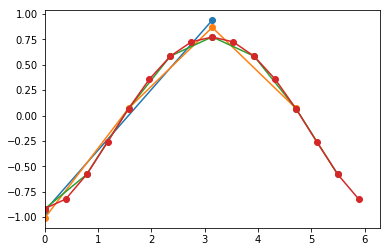

In [6]:
# Fourier spectral method for the Poisson problem
L = 2.0 * numpy.pi
f = lambda x: 1.0 / (1.0 - 0.6 * numpy.cos(2.0 * numpy.pi * x / L))

fig, axes = plt.subplots(1, 1)
for N in [2, 4, 8, 16]:
    delta_x = L / N
    delta_t = delta_x / 4.0
    x = numpy.linspace(0.0, delta_x * (N - 1), N)
    
    # Use the fft
    M = fft.fftfreq(N, 1.0 / N)
    k = 2.0 * numpy.pi * M / L

    F = fft.fft(f(x))
    if F[0] != 0:
        F = fft.fft(f(x) - F[0])
    U_hat = numpy.empty(N)
    U_hat[0] = 0.0
    U_hat[1:] = -F[1:] / k[1:]**2
    U = fft.ifft(U_hat).real

    axes.plot(x, U, 'o-')
    axes.set_xlim(0.0, L)

## Chebyshev Spectral Methods

So what happens when we are not on a periodic domain?  We could think of using polynomials instead of triginometric polynomials (our Fourier basis).  However from interpolation we know that using equally spaced points is a bad idea.  

Instead we will distribute the interpolation points such that
$$
    x_j = \cos(j \pi / N), ~~~ j=0, 1, \ldots, N,
$$
called the *Chebyshev points* of the second kind.

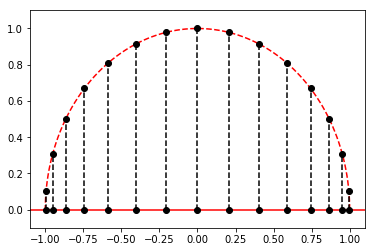

In [7]:
# Distribution of Chebyshev nodes
x = numpy.linspace(0, numpy.pi, 100)
N = 15

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(numpy.cos(x), numpy.sin(x), 'r--')
axes.plot(numpy.linspace(-1.1, 1.1, 100), numpy.zeros(x.shape), 'r')
for k in xrange(1, N + 1):
    location = [numpy.cos((2.0 * k - 1.0) * numpy.pi / (2.0 * N)),
                numpy.sin((2.0 * k - 1.0) * numpy.pi / (2.0 * N))]
    axes.plot(location[0], location[1], 'ko')
    axes.plot(location[0], 0.0, 'ko')
    axes.plot([location[0], location[0]], [0.0, location[1]], 'k--')
    
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-0.1, 1.1))
plt.show()

Using a Lagrange basis we can directly see how using equispaced points vs. Chebyshev points compare.

True


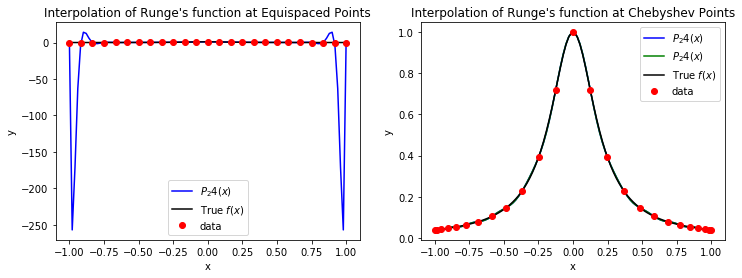

In [8]:
def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# Parameters
x = numpy.linspace(-1, 1, 100)
num_points = 25

# ============================================================
#  Equidistant nodes
equidistant_data = numpy.empty((num_points, 2))
equidistant_data[:, 0] = numpy.linspace(-1, 1, num_points)
equidistant_data[:, 1] = f(equidistant_data[:, 0])
N = equidistant_data.shape[0] - 1

lagrange_basis = numpy.ones((N + 1, x.shape[0]))
for i in xrange(N + 1):
    for j in xrange(N + 1):
        if i != j:
            lagrange_basis[i, :] *= (x - equidistant_data[j, 0]) / (equidistant_data[i, 0] - equidistant_data[j, 0])

# Calculate full polynomial
P_lagrange = numpy.zeros(x.shape[0])
for n in xrange(N + 1):
    P_lagrange += lagrange_basis[n, :] * equidistant_data[n, 1]

# ============================================================
#  Chebyshev nodes
chebyshev_data = numpy.empty((num_points, 2))
chebyshev_data[:, 0] = numpy.cos((2.0 * numpy.arange(1, num_points + 1) - 1.0) * numpy.pi / (2.0 * num_points))
chebyshev_data[:, 1] = f(chebyshev_data[:, 0])

# Create interpolant based on Chebyshev nodes
lagrange_basis = numpy.ones((N + 1, x.shape[0]))
for i in xrange(N + 1):
    for j in xrange(N + 1):
        if i != j:
            lagrange_basis[i, :] *= (x - chebyshev_data[j, 0]) / (chebyshev_data[i, 0] - chebyshev_data[j, 0])

# Calculate full polynomial
P_cheby1 = numpy.zeros(x.shape[0])
for n in xrange(N + 1):
    P_cheby1 += lagrange_basis[n, :] * chebyshev_data[n, 1]
    
# Fit directly with Chebyshev polynomials
coeff = numpy.polynomial.chebyshev.chebfit(chebyshev_data[:, 0], chebyshev_data[:, 1], N)
P_cheby2 = numpy.polynomial.chebyshev.chebval(x, coeff)

# Check on unique polynomials
print numpy.allclose(P_cheby1, P_cheby2)

# ============================================================
# Plot the results
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2.0)

axes = fig.add_subplot(1, 2, 1)
axes.plot(x, P_lagrange, 'b', label="$P_%s(x)$" % N)
axes.plot(x, f(x), 'k', label="True $f(x)$")
axes.plot(equidistant_data[:, 0], equidistant_data[:, 1], 'ro', label="data")
axes.set_title("Interpolation of Runge's function at Equispaced Points")
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.legend(loc=8)

axes = fig.add_subplot(1, 2, 2)
axes.plot(x, P_cheby1, 'b', label="$P_%s(x)$" % N)
axes.plot(x, P_cheby2, 'g', label="$P_%s(x)$" % N)
axes.plot(x, f(x), 'k', label="True $f(x)$")
axes.plot(chebyshev_data[:, 0], chebyshev_data[:, 1], 'ro', label="data")
          
axes.set_title("Interpolation of Runge's function at Chebyshev Points")
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.legend(loc=1)


plt.show()

There are two kinds of Chebyshev nodes which we will see both work as interpolating points equally as well.

1. Chebyshev nodes of the 1st kind (roots)
$$
    x_k = \cos \left (\frac{(2 k - 1) \pi}{2 N} \right ) ~~~~ k = 1, \ldots, N
$$
1. Chebyshev nodes of the 2nd kind (extrema)
$$
    x_k = \cos \left( \frac{k \pi}{N} \right) ~~~~ k = 0, \ldots, N
$$

[ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.        ]
[ 0.54030231  0.69021008  0.95263298  0.95263298  0.69021008  0.54030231]


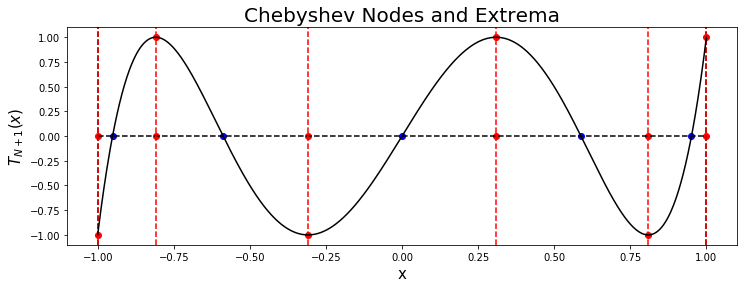

In [9]:
def cheb_poly(x, N):
    """Compute the *N*th Chebyshev polynomial and evaluate it at *x*"""
    T = numpy.empty((3, x.shape[0]))
    T[0, :] = numpy.ones(x.shape)
    T[1, :] = x
    for k in xrange(2, N):
        T[2, :] = 2.0 * x * T[1, :] - T[0, :]
        T[0, :] = T[1, :]
        T[1, :] = T[2, :]
    
    return T[2, :]

N = 5
x_extrema = numpy.cos(numpy.arange(N + 1) * numpy.pi / N)
x_nodes = numpy.cos((2.0 * numpy.arange(1, N + 1) - 1.0) / (2.0 * N) * numpy.pi)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 1, 1)

# Plot points
axes.plot(x_extrema, numpy.zeros(N+1), 'ro')
axes.plot(x_nodes, numpy.zeros(N), 'bo')
    
# Plot some helpful lines
axes.plot((-1.0, -1.0), (-1.1, 1.1), 'k--')
axes.plot((1.0, 1.0), (-1.1, 1.1), 'k--')
axes.plot((-1.0, 1.0), (0.0, 0.0), 'k--')
for i in xrange(x_extrema.shape[0]):
    axes.plot((x_extrema[i], x_extrema[i]), (-1.1, 1.1), 'r--')
    axes.plot(x_extrema[i], cheb_poly(x_extrema, N + 1)[i], 'ro')

print x_extrema
print numpy.cos(x_extrema)
    
# Plot Chebyshev polynomial
x_hat = numpy.linspace(-1, 1, 1000)
axes.plot(x_hat, cheb_poly(x_hat, N + 1), 'k')
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))

# Labels
axes.set_title("Chebyshev Nodes and Extrema", fontsize="20")
axes.set_xlabel("x", fontsize="15")
axes.set_ylabel("$T_{N+1}(x)$", fontsize="15")

plt.show()

Another interesting property of Chebyshev nodes is that they nest with different periods.  The first-kind nodes nest with factors of 3 while the second-kind nest every 2.  This can be useful if you have already spent the effort to find function evaluations at a lower resolution set of nodes but want to increase the number of points being used.  If you use this nesting factor you can retain the locations of your nodes and data while still increasing the resolution.

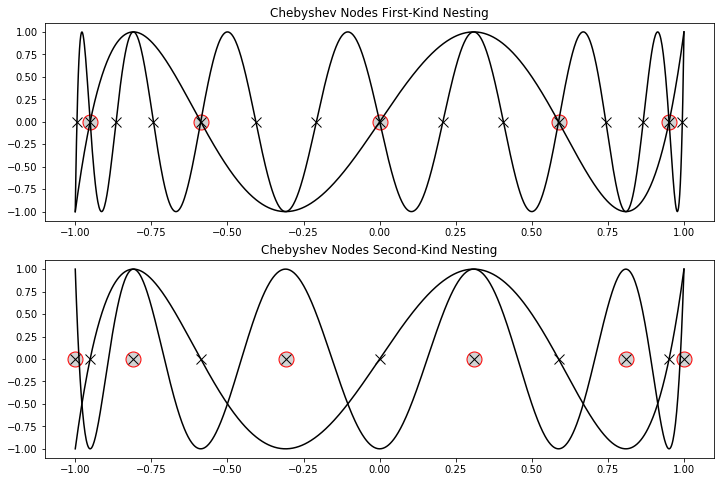

In [10]:
# First-kind Nesting (3 x)
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(2, 1, 1)

N = 5
factor = 3
x_1 = numpy.cos((2.0 * numpy.arange(1, N + 1) - 1.0) / (2.0 * N) * numpy.pi)
x_2 = numpy.cos((2.0 * numpy.arange(1, factor * N + 1) - 1.0) / (2.0 * factor * N) * numpy.pi)

axes.plot(x_1, numpy.zeros(N), "o", color="r", markerfacecolor="lightgray", markersize="15")
axes.plot(x_2, numpy.zeros(N * factor), 'kx', markersize="10")

x_hat = numpy.linspace(-1, 1, 1000)
axes.plot(x_hat, cheb_poly(x_hat, N + 1), 'k')
axes.plot(x_hat, cheb_poly(x_hat, factor * N + 1), 'k')
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.set_title("Chebyshev Nodes First-Kind Nesting")

# Second-kind Nesting (2 x)
axes = fig.add_subplot(2, 1, 2)
N = 5
factor = 2
x_1 = numpy.cos(numpy.arange(N + 1) * numpy.pi / N)
x_2 = numpy.cos(numpy.arange(factor * N + 1) * numpy.pi / (factor * N))

axes.plot(x_1, numpy.zeros(N + 1), "o", color="r", markerfacecolor="lightgray", markersize="15")
axes.plot(x_2, numpy.zeros(N * factor + 1), 'kx', markersize="10")

x_hat = numpy.linspace(-1, 1, 1000)
axes.plot(x_hat, cheb_poly(x_hat, N + 1), 'k')
axes.plot(x_hat, cheb_poly(x_hat, factor * N + 1), 'k')
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.set_title("Chebyshev Nodes Second-Kind Nesting")

One way to gauge the Chebyshev nodes' optimality as a set of interpolation points is to consider the Lebesgue function
$$
\lambda_N(x)  = \sum_{i=0}^N\big{|}\ell_i(x)\big{|}
$$
where $\ell_i(x)$ are Lagrange basis functions for a given set of $x_i$.  The maximum of the Lebesgue function is called $\Lambda_n$ the Lebesgue constant and are clearly related to Lagrangian interpolation as they provide a first estimate for the interpolation error.  Unfortunately, $\Lambda_N$ is not uniformly bounded regardless of the nodes used as one can show that 
$$
    \Lambda_N > \mathcal{O}(\log N) ~~~\text{as}~~~ N \rightarrow \infty
$$
Note $\Lambda_n$ is the infinite-norm of the linear operator mapping data to interpolant on the given grid and interval.

If we compute these functions for equispaced points and each Chebyshev node kind we can see why Chebyshev may be significantly better for interpolating.

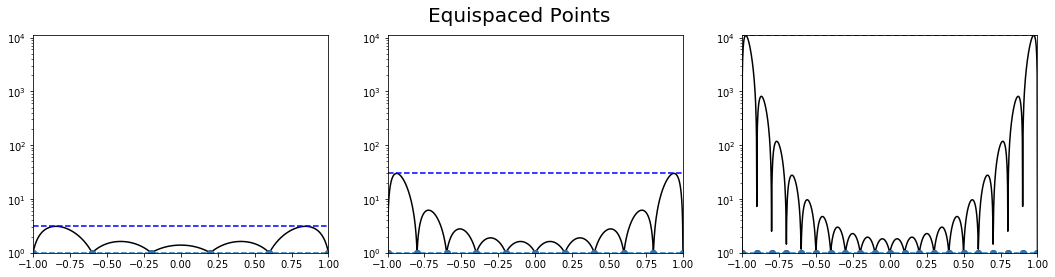

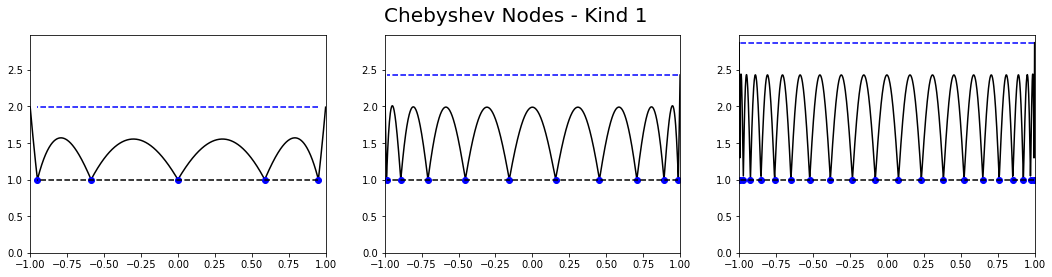

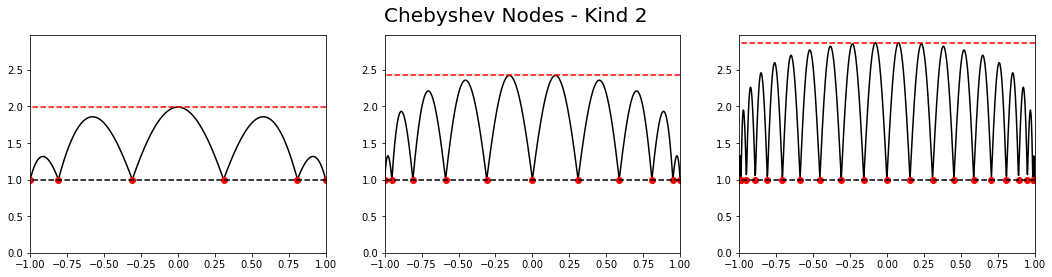

In [11]:
def lebesgue(x, data):
    """Compute the *i*th Lagrangian basis
    
    :Input:
     - *x* (numpy.ndarray) x values that basis will be evaluated at
     - *data* (numpy.ndarray) Tuples representing interpolant points
     - *i* (int) Which basis function to compute.
     
    :Output:
     - (numpy.ndarray) Contains the ith Lagrangian basis evaluated at x
    """
    
    lebesgue = numpy.zeros(x.shape[0])
    for i in xrange(data.shape[0]):
        lagrange_basis = numpy.ones(x.shape[0])
        for j in xrange(data.shape[0]):
            if i != j:
                lagrange_basis *= (x - data[j]) / (data[i] - data[j])
        lebesgue += numpy.abs(lagrange_basis)
    return lebesgue

N_range = [5, 10, 20]
x = numpy.linspace(-1, 1, 1000)

# Equispaced
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
fig.suptitle("Equispaced Points", fontsize="20")
y_max = 0.0
axes = []
for (i, N) in enumerate([5, 10, 20]):
    x_hat = -1.0 + 2.0 * numpy.arange(N + 1) / N
    y = lebesgue(x, x_hat)
    axes.append(fig.add_subplot(1, 3, i + 1))
    axes[i].semilogy(x, y, 'k')
    axes[i].semilogy(x_hat, numpy.ones(N + 1), 'ro')
    axes[i].semilogy(x_hat, numpy.ones(N + 1), 'o--')
    axes[i].plot(x_hat, numpy.ones(N + 1) * numpy.max(y), 'b--')
    axes[i].set_xlim((-1, 1))
    y_max = max(y_max, numpy.max(y))
for i in xrange(len(N_range)):
    axes[i].set_ylim((0.0, y_max + 0.1))

# Chebysehv Nodes
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
fig.suptitle("Chebyshev Nodes - Kind 1", fontsize="20")
y_max = 0.0
axes = []
for (i, N) in enumerate(N_range):
    x_hat = numpy.cos((2.0 * numpy.arange(1, N + 1) - 1.0) / (2.0 * N) * numpy.pi)
    y = lebesgue(x, x_hat)
    axes.append(fig.add_subplot(1, 3, i + 1))
    axes[i].plot(x, y, 'k')
    axes[i].plot(x_hat, numpy.ones(N), 'bo')
    axes[i].plot(x_hat, numpy.ones(N), 'k--')
    axes[i].plot(x_hat, numpy.ones(N) * numpy.max(y), 'b--')
    axes[i].set_xlim((-1, 1))
    y_max = max(y_max, numpy.max(y))
for i in xrange(len(N_range)):
    axes[i].set_ylim((0.0, y_max + 0.1))
    
# Chebyshev extrema - note that the maxima are the same
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
fig.suptitle("Chebyshev Nodes - Kind 2", fontsize="20")
y_max = 0.0
axes = []
for (i, N) in enumerate(N_range):
    x_hat = numpy.cos(numpy.arange(N + 1) * numpy.pi / N)
    y = lebesgue(x, x_hat)
    axes.append(fig.add_subplot(1, 3, i + 1))
    axes[i].plot(x, y, 'k')
    axes[i].plot(x_hat, numpy.ones(N + 1), 'ro')
    axes[i].plot(x_hat, numpy.ones(N + 1), 'k--')
    axes[i].plot(x_hat, numpy.ones(N + 1) * numpy.max(y), 'r--')
    axes[i].set_xlim((-1, 1))
    y_max = max(y_max, numpy.max(y))
for i in xrange(len(N_range)):
    axes[i].set_ylim((0.0, y_max + 0.1))

To actually show that the Chebyshev nodes are optimal consider the monic polynomial $p(z)$ in the complex plane of degree $N$
$$
    p(z) = \prod^N_{k=1} (z - z_k)
$$
where $z_k$ are the roots with possible non-trivial multiplicity.  Manipulating this a bit we can also write the related expressions
$$\begin{aligned}
    |p(z)| &= \prod^N_{k=1} |z - z_k| \\
    \log|p(z)| &= \sum^N_{k=1} \log|z - z_k|.
\end{aligned}$$

Let
$$
    \phi_N(z) = \frac{1}{N} \sum^N_{k=1} \log |z - z_k|,
$$
Since $\phi_N(z)$ is *harmonic* it satisfies Laplace's equation in the complex plane except at the roots $z_k$.  This setup can be viewed as an electrostatic potential with charges at the roots $z_k$.  The potential from each of the charges is
$$
    \frac{\log |z - z_k|}{N}.
$$

Consider now the relationship between $|p(z)|$ and $\phi_N(z)$.  From our previous expressions we know that
$$
    |p(z)| = e^{N \phi_N(z)}.
$$

If $\phi_N(z)$ is roughly constant on the interval $[-1, 1]$ then $|p(z)|$ is as well.  If on the other hand $\phi_N(z)$ varies then the variation of $|p(z)|$ will be exponential, especially with large $N$!  With an eye towards this behavior consider the $N \rightarrow \infty$ limit and consider the points $x_j$ distributed in $[-1, 1]$ according to a density function $\rho(x)$ with
$$
    \int^1_{-1} \rho(x) dx = 1.
$$

From this density function we also know the number of grid points in an interval $[a, b]$ as
$$
    1 = N \int^b_a \rho(x) dx.
$$

Using this framework we can write the potential as
$$
    \phi(z) = \int^1_{-1} \rho(x) \log |z - x| dx.
$$
In the limit $N \rightarrow \infty$ we can show for equispaced points that
$$
    \phi(z) = -1 +\frac{1}{2} \Re((z + 1) \log(z + 1) - (z-1)\log(z-1)).
$$
Note that $\phi(0) = -1$ and $\phi(\pm 1) = -1 + \log 2$ which implies that if a polynomial $p$ has equispaced roots on $[-1, 1]$ then it will take values that are $2^N$ larger near the points $\pm 1$ than near $0$.

Instead if we consider the distribution for the Chebyshev points
$$
    \rho(x) = \frac{1}{\pi \sqrt{1 - x^2}}, ~~~ x\in[-1,1]
$$
we are lead to the potential
$$
    \phi(z) = \log\frac{|z - \sqrt{z^2 - 1}|}{2}.
$$

Interestingly these formula have a simple interpretation, the level curves of $\phi(z)$ are the ellipses with foci $\pm 1$.  The value of $\phi(z)$ along any such ellipse is the logarithm of half the sum of the semimajor and minor axes of the ellipses.  The degenerate ellipse $[-1, 1]$ is a level curve as well and takes on the constant value $-\log 2$.  This turns out to be optimal with the polynomial growing as
$$
    |p(z)| = e^{N \phi(x)} \approx 2^{-N}, ~~~ x\in[-1,1].
$$

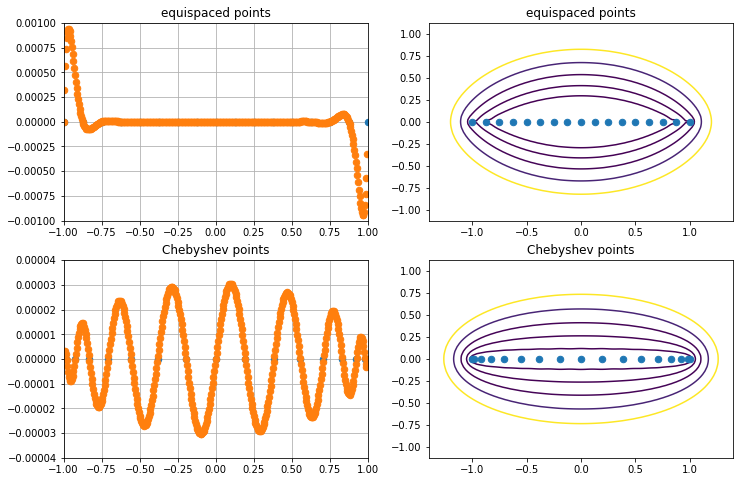

In [12]:
# Adapted from program 10 in Trefethen - "Spectral Methods for MATLAB"
N = 16

fig, axes = plt.subplots(2, 2)
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)

for (i, point_distribution) in enumerate(("equispaced points", "Chebyshev points")):
    if i == 0:
        x = -1.0 + 2.0 * numpy.arange(N + 1) / N
    else:
        x = numpy.cos(numpy.pi * numpy.arange(N+1) / N)
    
    # Construct polynomial with roots at x
    p = numpy.poly(x)
    
    # Plot p(x) over [-1, 1]
    x_fine = numpy.arange(-1, 1, .005)
    axes[i, 0].plot(x, 0*x, '.', markersize=13)
    axes[i, 0].plot(x_fine, numpy.polyval(p, x_fine), '.', markersize=13)
    axes[i, 0].grid(True)
    axes[i, 0].set_title(point_distribution)
    axes[i, 0].set_xlim((-1, 1))
    if i == 0:
        axes[i, 0].set_ylim((-1e-3, 1e-3))
    else:
        axes[i, 0].set_ylim((-4e-5, 4e-5))
    
    # Plot equipotential curves
    axes[i, 1].plot(x.real, x.imag, '.', markersize=13)
    axes[i, 1].set_xlim((-1.4, 1.4))
    axes[i, 1].set_ylim((-1.12, 1.12))
    X, Y = numpy.meshgrid(numpy.arange(-1.4, 1.4, 0.02), 
                          numpy.arange(-1.12, 1.12, 0.02))
    levels = 10**(numpy.arange(-4.0, 1.0))
    axes[i, 1].contour(X, Y, numpy.abs(numpy.polyval(p, X + 1j * Y)), levels)
    axes[i, 1].set_title(point_distribution)

### Chebyshev Differentiation

One way we can derive finite differences is by interpolating a polynomial through the stencil points and taking the derivative of the resulting interpolant.  We can do the same thing to find Chebyshev differentiation matrices.  Since any interpolant is unique based on the points it passes through we just need to determine the derivative based on the Chebyshev nodes themselves.

Let
$$
   p_N(x_j) = v_j, ~~ 0 \leq j \leq N 
$$
be the polynomial of degree $N$, then the resulting derivative is
$$
    p'_N(x_j) = w_j.
$$

Since this operation is linear we can form this as multiplication by a matrix:
$$
    \mathbf{w} = \mathbf{D}_N \mathbf{v}
$$

As an example consider the case when $N=1$, then the interpolating points are $x_0 = 1$ and $x_1 = -1$ leading to
$$
    p_1(x) = \frac{1}{2} (1  + x)v_0 + \frac{1}{2}(1 - x)v_1
$$
for which
$$
    p'_1(x) = \frac{1}{2}(v_0 - v_1).
$$
The resulting matrix is then
$$
    D_1 = \begin{bmatrix}
        1/2 & -1/2 \\
        1/2 & -1/2
    \end{bmatrix}.
$$

For the $N=2$ case we have the points $x_0 = 1$, $x_1 = 0$, and $x_2 = -1$ with the quadratic interpolant
$$
    p_2(x) = \frac{1}{2} x ( 1 + x) v_0 + (1+x)(1-x)v_1 + \frac{1}{2} x (x-1) v_2
$$
leading to the derivative
$$
    p'_2(x) = (x+ 1/2) v_0 - 2 x v_1 + (x-1/2)v_2
$$
and differentiation matrix
$$
    D_2 = \begin{bmatrix}
        3/2  & -2 & 1/2 \\
        1/2  &  0 & -1/2 \\
        -1/2 &  2 & -3/2
    \end{bmatrix}.
$$

Note that for both of these cases these formulas take on a familiar form, however their differentiation matrices have additional one sided properties.  For high-order approximations these depart from the usual finite difference methods due to the uneven spacing of the points.  In general the Chebyshev differentiation matrices take the form
$$\begin{aligned}
    (D_N)_{00} = \frac{2 N^2 + 1}{6}, & & (D_N)_{NN} = -\frac{2N^2 + 1}{6}, \\
    (D_N)_{jj} = \frac{-x_j}{2(1 - x_j^2)}, & & j=1,\ldots,N-1 \\
    (D_N)_{ij} = \frac{c_i(-1)^{i+j}}{c_j (x_i - x_j)}, & & i\neq j, ~~ i,j = 0, \ldots, N
\end{aligned}$$
where
$$
    c_i = \left \{ \begin{aligned}
        2, & & i=0 \text{ or } N \\
        1, & & \text{otherwise}.
    \end{aligned} \right .
$$

In [13]:
# Based on Trefethen cheb function and
# the post at http://www.scientificpython.net/pyblog/pseudospectral-differentiation
import operator
import scipy

def cheb(N):
    x = numpy.cos(numpy.pi * numpy.arange(N+1) / N)
    e = scipy.ones((N + 1, 1))
    Xdiff = scipy.outer(x, e) - scipy.outer(e, x) + scipy.identity(N + 1)
    xprod = -reduce(operator.mul, Xdiff) # product of rows
    W = scipy.outer(1.0 / xprod, e)
    D = W / scipy.multiply(W.T, Xdiff)
    d = 1-sum(D)

    for k in range(0, N+1):  # Set diagonal elements
        D[k,k] = d[k]

    return -D.T, x

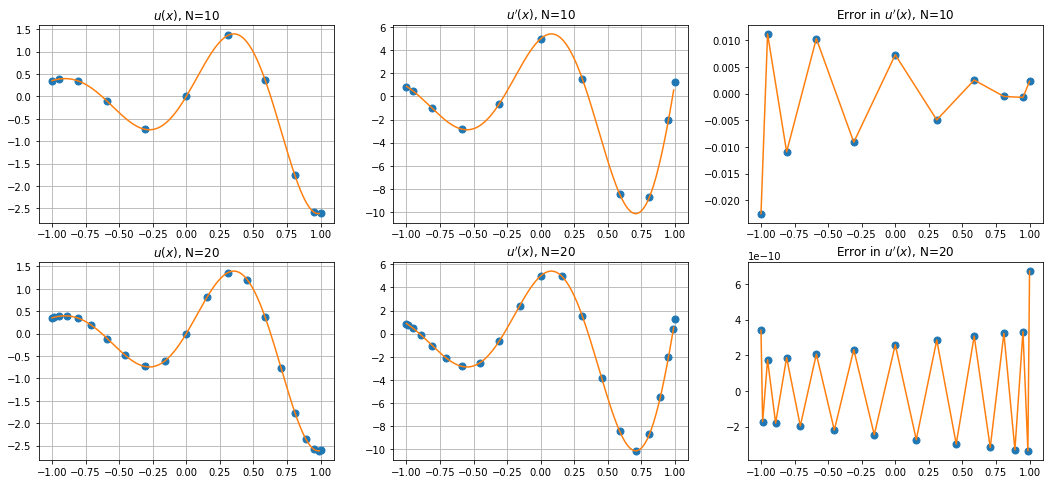

In [14]:
# Test out some differentiation on a smooth function
u = lambda x: numpy.exp(x) * numpy.sin(5.0 * x)
u_prime = lambda x: numpy.exp(x) * (numpy.sin(5.0 * x) + 5.0 * numpy.cos(5.0 * x))

x_fine = numpy.arange(-1, 1, 0.01)
fig, axes = plt.subplots(2, 3)
fig.set_figwidth(fig.get_figwidth() * 3)
fig.set_figheight(fig.get_figheight() * 2)
for (i, N) in enumerate((10, 20)):
    D, x = cheb(N)
    axes[i, 0].plot(x, u(x), '.', markersize=14)
    axes[i, 0].grid(True)
    axes[i, 0].plot(x_fine, u(x_fine))
    axes[i, 0].set_title('$u(x)$, N=%s' % N)

    axes[i, 1].plot(x, numpy.dot(D, u(x)), '.', markersize=14)
    axes[i, 1].grid(True)
    axes[i, 1].plot(x_fine, u_prime(x_fine))
    axes[i, 1].set_title("$u'(x)$, N=%s" % N)
    
    error = numpy.dot(D, u(x)) - u_prime(x)
    axes[i, 2].plot(x, error, '.', markersize=14)
    axes[i, 2].plot(x, error)
    axes[i, 2].set_title("Error in $u'(x)$, N=%s" % N)

plt.show()

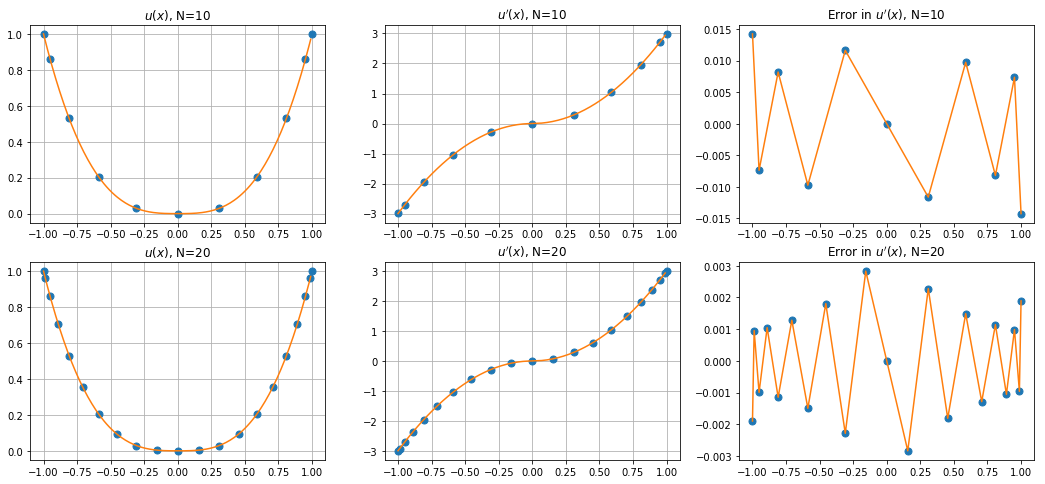

In [15]:
# Bounded Variation in 3rd derivative
u = lambda x: numpy.abs(x)**3
u_prime = lambda x: 3.0 * x * numpy.abs(x)

x_fine = numpy.arange(-1, 1, 0.01)
fig, axes = plt.subplots(2, 3)
fig.set_figwidth(fig.get_figwidth() * 3)
fig.set_figheight(fig.get_figheight() * 2)
for (i, N) in enumerate((10, 20)):
    D, x = cheb(N)
    axes[i, 0].plot(x, u(x), '.', markersize=14)
    axes[i, 0].grid(True)
    axes[i, 0].plot(x_fine, u(x_fine))
    axes[i, 0].set_title('$u(x)$, N=%s' % N)

    axes[i, 1].plot(x, numpy.dot(D, u(x)), '.', markersize=14)
    axes[i, 1].grid(True)
    axes[i, 1].plot(x_fine, u_prime(x_fine))
    axes[i, 1].set_title("$u'(x)$, N=%s" % N)
    
    error = numpy.dot(D, u(x)) - u_prime(x)
    axes[i, 2].plot(x, error, '.', markersize=14)
    axes[i, 2].plot(x, error)
    axes[i, 2].set_title("Error in $u'(x)$, N=%s" % N)

plt.show()

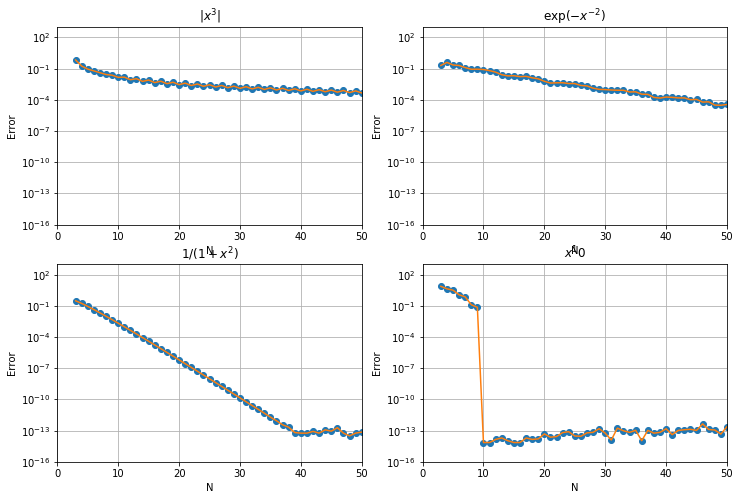

In [16]:
# Compare errors more carefully (program 12 in Trefethen)
N_max = 50
error = numpy.zeros((4, N_max - 2))
N_range = numpy.arange(3, N_max + 1)
for (i, N) in enumerate(N_range):
    D, x = cheb(N)
    # 3rd derivative of bounded variation
    v = numpy.abs(x)**3
    v_prime = numpy.abs(x) * x * 3.0
    error[0, i] = numpy.linalg.norm(numpy.dot(D, v) - v_prime, ord=numpy.infty)
    # C_\infty function
    v = numpy.exp(-x**(-2))
    v_prime = 2 * v / x**3
    error[1, i] = numpy.linalg.norm(numpy.dot(D, v) - v_prime, ord=numpy.infty)
    # Analytic on [-1, 1]
    v = 1.0 / (1.0 + x**2)
    v_prime = -2.0 * x * v**2
    error[2, i] = numpy.linalg.norm(numpy.dot(D, v) - v_prime, ord=numpy.infty)
    # Polynomial
    v = x**10
    v_prime = 10 * x**9
    error[3, i] = numpy.linalg.norm(numpy.dot(D, v) - v_prime, ord=numpy.infty)
    
# Plot errors
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
titles = ['$|x^3|$', '$\exp(-x^{-2})$', '$1 / (1 + x^2)$', '$x^10$']
for (i, title) in enumerate(titles):
    axes = fig.add_subplot(2, 2, i + 1)
    axes.semilogy(N_range, error[i, :], '.', markersize=12)
    axes.semilogy(N_range, error[i, :])
    axes.set_xlim((0, N_max))
    axes.set_ylim((1e-16, 1e3))
    axes.grid(True)
    axes.set_xlabel("N")
    axes.set_ylabel("Error")
    axes.set_title(title)

As another application of the Chebyshev differentiation matrix we can also use it to compute the solution to a Poisson problem with non-periodic boundary conditions.  Consider the problem
$$
    u_{xx} = e^{4x}, ~~~ \Omega = [-1, 1], ~~~ u(\pm 1) = 0
$$
which has the solution
$$
    u(x) = \frac{e^{4x} - x \sinh(4) - \cosh(4)}{16}.
$$
Proceeding from before we then have
$$
    D^2_N U = F
$$
which can then be inverted to find the solution.

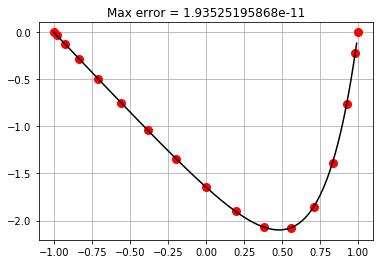

In [17]:
# Adapted from Trefethen program 13
f = lambda x: numpy.exp(4.0 * x)
u_true = lambda x: (numpy.exp(4.0 * x) - x * numpy.sinh(4.0) - numpy.cosh(4.0)) / 16.0

N = 16
x_fine = numpy.arange(-1, 1, 0.01)

# Compute square and remove boundaries
D, x = cheb(N)
D2 = numpy.dot(D, D)[1:-1, 1:-1]

# Solve problem
U = numpy.zeros(N + 1)
U[1:-1] = numpy.linalg.solve(D2, f(x[1:-1]))
error = numpy.linalg.norm(U - u_true(x), ord=numpy.infty)

# Plot results
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, U, 'r.', markersize=16)
axes.plot(x_fine, u_true(x_fine), 'k')
axes.grid(True)
axes.set_title("Max error = %s" % error)
plt.show()

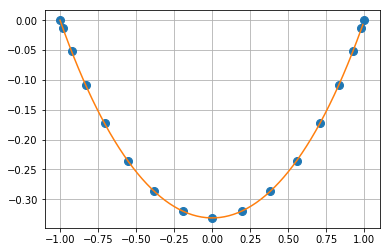

In [18]:
# Adapted from Trefethen program 14 - Non-linear Elliptic
f = lambda u: numpy.exp(u)

N = 16
x_fine = numpy.arange(-1, 1, 0.01)

# Compute square and remove boundaries
D, x = cheb(N)
D2 = numpy.dot(D, D)[1:-1, 1:-1]

# Solve problem using fixed point iteration
U = numpy.zeros(N + 1)
U_new = numpy.zeros(N + 1)
delta = 1.0
step = 0
while delta > 1e-15:
    U_new[1:-1] = numpy.linalg.solve(D2, f(U[1:-1]))
    delta = numpy.linalg.norm(U_new - U, ord=numpy.infty)
    U = U_new
    step += 1

# Plot results
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, U, '.', markersize=16)
U_interp = numpy.polyval(numpy.polyfit(x, U, N), x_fine)
axes.plot(x_fine, U_interp, '-')
axes.grid(True)
plt.show()

We can also do higher-dimensional problems.  Consider the PDE
$$
    u_{xx} + u_{yy} = 10 \sin(8 x (y - 1)), ~~~ -1 < x,~y < 1
$$
with $u = 0$ on the boundary.  We can continue to use the differentiation matrix we used above.  If we order the unknowns in the natural ordering from before we can again use the Kronecker product to construct the relevant matrices.  

For instance, if we consider the $N=4$ case we have the differentiation matrix in one-dimension
$$
    D^2_4 = \begin{bmatrix}
        -14 & 6 & -2 \\
        4 & -6 & 4 \\
        -2 & 6 & -14
    \end{bmatrix}
$$
which can approximate the x-dimension matrix with the ordering specified as `kron(I, D2)` which leads to
$$
    I \otimes D^2_N = \begin{bmatrix}
        -14 & 6 & -2 \\
        4 & -6 & 4 \\
        -2 & 6 & -14 \\
        & & & -14 & 6 & -2 \\
        & & & 4 & -6 & 4 \\
        & & & -2 & 6 & -14 \\
        & & & & & & -14 & 6 & -2 \\
        & & & & & & 4 & -6 & 4 \\
        & & & & & & -2 & 6 & -14
    \end{bmatrix}.
$$

The derivative in the y-direction would be `kron(D2, I)` leading to
$$
    I \otimes D^2_N = \begin{bmatrix}
        -14 &     &     &   6 &     &     &  -2 &     &     \\
            & -14 &     &     &   6 &     &     &  -2 &     \\
            &     & -14 &     &     &   6 &     &     &  -2 \\
          4 &     &     &  -6 &     &     &   4 &     &     \\
            &   4 &     &     &  -6 &     &     &   4 &     \\
            &     &   4 &     &     &  -6 &     &     &   4 \\
         -2 &     &     &   6 &     &     & -14 &     &     \\
            &  -2 &     &     &   6 &     &     & -14 &     \\
            &     &  -2 &     &     &   6 &     &     & -14 \\
    \end{bmatrix}.
$$

All together we can get the discretized Laplacian operator by adding the two matrices above with
$$
    L_N = I \otimes D^2_N + D^2_N \otimes I.
$$

The drawback to using these matrices vs. finite differences is that the matrices are not as sparse.  Luckily, if we can leverage the spectral convergence of these methods we will be able to use far less points to solve the system.

u(\sqrt{2}, \sqrt{2}) = 0.320715945108


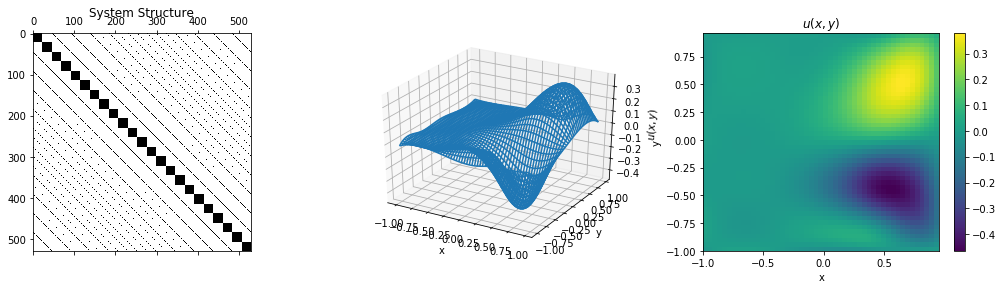

In [23]:
# Based on Trefethen program 16
import mpl_toolkits.mplot3d
import scipy.interpolate

f = lambda x, y: 10.0 * numpy.sin(8.0 * x * (y - 1.0))

N = 24
D, x = cheb(N)
X, Y = numpy.meshgrid(x[1:-1], x[1:-1])
X = X.flatten()
Y = Y.flatten()

D2 = numpy.dot(D, D)
D2 = D2[1:-1, 1:-1]
I = numpy.eye(N - 1)
L = numpy.kron(I, D2) + numpy.kron(D2, I)

# Solve system
U = numpy.linalg.solve(L, f(X, Y))

# Plot system structure and results
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)

axes = fig.add_subplot(1, 3, 1)
axes.spy(L)
axes.set_title("System Structure")

u = numpy.zeros((N + 1, N + 1))
u[1:-1, 1:-1] = U.reshape(N - 1, N - 1)
X, Y = numpy.meshgrid(x, x)
x_fine = numpy.arange(-1, 1, 0.04)
X_fine, Y_fine = numpy.meshgrid(x_fine, x_fine)
u_interpolant = scipy.interpolate.bisplrep(X, Y, u, s=1)
u_fine = scipy.interpolate.bisplev(x_fine, x_fine, u_interpolant)

axes = fig.add_subplot(1, 3, 2, projection='3d')
axes.plot_wireframe(X_fine, Y_fine, u_fine)
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('$u(x,y)$')

axes = fig.add_subplot(1, 3, 3)
plot = axes.pcolor(X_fine, Y_fine, u_fine)
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('$u(x,y)$')
fig.colorbar(plot)

plt.show()

## FFT and Chebyshev

The FFT is a powerful tool that really makes spectral methods attractive but we have only seen how it can be used on the Fourier series.  It turns out a set of equivalencies will allow us to use the FFT on the Chebyshev series as well.

![Relationships between x, z, and \theta (from Trefethen fig 8.1)](./images/relationships.png)

Let $z \in \mathbb C$ such that $|z| = 1$, let $\theta$ be the argument of $z$, i.e. $z = e^{i \theta}$ (note that $\theta$ is only unique up to multiples of $2 \pi$), and $x$ be the real part of $z$ so that $x = \Re z = \cos \theta$.  For all $x \in [-1, 1]$ there two values of $z$ corresponding to going up and down to the corresponding $z$ on the unit circle which are
$$
    x = \Re z = \frac{1}{2} (z + z^{-1}) = \cos \theta.
$$

Now consider the Chebyshev polynomials $T_n(x)$ for which the $n+1$ polynomial is
$$
    T_{n+1}(x) = \frac{1}{2} (z^{n+1} + z^{-n-1}) = \frac{1}{2} (z^n + z^{-n}) - \frac{1}{2}(z^{n-1} + z^{1-n})
$$
which also corresponds to the recurrence relation for Chebyshev polynomials of
$$
    T_{n+1}(x) = 2 x T_n(x) - T_{n-1}(x).
$$
Note that we are actually using the relationship between $x$ and $z$ we have from the unit circle relationship.

Since we also know that $T_n(x)$ is a polynomial of degree $n$ we can use the Chebyshev polynomials as a basis
$$
    p(x) = \sum^\infty_{n=0} a_n T_n(x), ~~~~ x \in [-1, 1].
$$
This also corresponds to an $N$ degree Laurent polynomial in $z$ and $z^{-1}$ such that $z^n$ and $z^{-n}$ have equal coefficients
$$
    \tilde{p}(z) = \frac{1}{2} \sum^\infty_{n=0} a_n (z^n + z^{-n}), ~~~~ |z| = 1,
$$
also known as self-reciprocal.  There is yet another polynomial in $\theta$ that is $2 \pi$ periodic such that
$$
    P(\theta) = \sum^\infty_{n=0} a_n \cos n \theta, ~~~~ \theta \in \mathbb R.
$$

So where does this take us?  We know that these polynomials are equivalent if we have the relationships we originally defined between the independent variables $x$, $z$, and $\theta$.  Let's now consider how these polynomials would act as interpolants.

Let $f(x)$ be some arbitrary function on $[-1, 1]$, we can then form a self-reciprocal function $\tilde{f}(z)$ with
$$
    \tilde{f}(z) = f(1/2 (z + z^{-1})
$$
and correspondingly
$$
    F(\theta) = f(\cos \theta).
$$

Now let's see how a truncated version of our polynomials interpolate these functions.  The interpolants will have nodal points at
$$
    \theta_j = j \pi / N, ~~~~ z_j = e^{i\theta_j}, ~~~~ \text{and}  ~~~~ x_j = \cos \theta_j = \Re z_j.
$$
With these in hand we can make the following statements regarding these truncated polynomials with regards to a function $f(z)$:
 - $P(\theta)$ interpolates $F(\theta)$ (assuming that it is even and 2 \pi-periodic) in the equispaced points $\theta_j$,
 - $\tilde{p}(z)$ interpolates $\tilde{z}$ in the roots of unity $z_j$
 - $p(x)$ interpolates $f(x)$ at the Chebyshev points $x_j$
 

We can now begin to see how we might be able to use the FFT with Chebyshev series due to these equivalencies.  The basic process is as follows:
1. Given $f$ arbitrary, find the trigonometric polynomial interpolant $Q$ of $F$,
2. Differentiate this interpolant in Fourier space, and
3. Transform back to the original domain on $x \in [-1, 1]$.

In [20]:
# Based on Trefethen chebfft function
def chebfft(v):
    N = v.shape[0] - 1
    if N == 0:
        return 0
    x = numpy.cos(numpy.arange(N+1) * numpy.pi / N)
    ii = numpy.arange(N)
    
    # Transform x to \theta
    V = numpy.hstack((v, v[N-1:0:-1]))
    U = fft.fft(V).real
    wave_numbers = numpy.hstack((ii, [0], numpy.arange(1-N, 0)))
    W = fft.ifft(1j * wave_numbers * U).real
    w = numpy.zeros((N+1))
    
    # Transform back to x from \theta
    w[1:N] = -W[1:N] / numpy.sqrt(1.0 - x[1:N]**2)
    w[0] = numpy.sum(ii**2 * U[ii]) / N + 0.5 * N * U[N]
    w[-1] = numpy.sum((-1)**(ii + 1) * ii**2 * U[ii]) / N + 0.5 * (-1)**(N+1) * N * U[N]
    
    return w

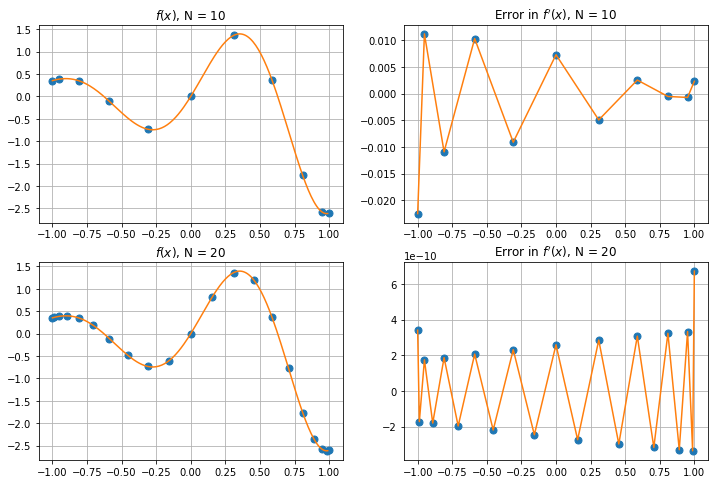

In [21]:
# Adaptation of program 18 in Trefethen
f = lambda x: numpy.exp(x) * numpy.sin(5.0 * x)
f_prime = lambda x: numpy.exp(x) * (numpy.sin(5.0 * x) + 5.0 * numpy.cos(5.0 * x))
x_fine = numpy.arange(-1, 1, 0.01)

fig, axes = plt.subplots(2, 2)
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
for (i, N) in enumerate((10, 20)):
    x = numpy.cos(numpy.pi * numpy.arange(N+1) / N)
    axes[i, 0].plot(x, f(x), '.', markersize=14)
    axes[i, 0].plot(x_fine, f(x_fine))
    axes[i, 0].grid(True)
    axes[i, 0].set_title("$f(x)$, N = %s" % N)
    
    error = chebfft(f(x)) - f_prime(x)
    axes[i, 1].plot(x, error, '.', markersize=14)
    axes[i, 1].plot(x, error)
    axes[i, 1].grid(True)
    axes[i, 1].set_title("Error in $f'(x)$, N = %s" % N)

We can also apply these methods to solving PDEs using the Chebyshev spectral method in the spatial direction and some time-discretization in the time direction.   Consider the second order wave equation
$$
    u_{tt} = u_{xx}
$$
on $\Omega = [-1, 1]$ and boundary conditions set to $0$.  We will again use leapfrog to do the time integration.

In [22]:
# Based on program 19 of Trefethen
# Solve the 2nd order wave equation on Chebyshev grid via leapfrog

N = 80
x = numpy.cos(numpy.pi * numpy.arange(0, N+1) / N)
delta_t = 8.0 / N**2
U = numpy.exp(-200.0 * x**2)
U_old = numpy.exp(-200.0 * (x - delta_t)**2)
t_final = 4.0

num_steps = int(numpy.ceil(t_final / delta_t))
plot_interval = 20
t = numpy.linspace(0.0, t_final, num_steps)
num_output = num_steps / plot_interval
t_output = numpy.empty(num_output)
U_output = numpy.empty((x.shape[0], num_output))
for n in xrange(num_steps):
    U_hat_dbl_prime = chebfft(chebfft(U))
    U_hat_dbl_prime[0] = 0.0
    U_hat_dbl_prime[-1] = 0.0
    
    U_new = 2.0 * U - U_old + delta_t**2 * U_hat_dbl_prime
    U_old = U.copy()
    U = U_new

    t += delta_t
    if numpy.mod(n, plot_interval) == 0:
        i = 
        t_output[] = t_output.append(t)
        U_output.append(U)

fig = plt.figure()
# fig.set_figwidth(fig.get_figwidth() * 2)
# fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1)
print x.shape, len(t_output), len(U_output)
plot = axes.pcolor(x, t_output, U_output)
axes.set_xlabel("x")
axes.set_ylabel("t")
axes.set_title("$U(x,t)$")
fig.colorbar(plot)

plt.show()

SyntaxError: invalid syntax (<ipython-input-22-70873b1e200c>, line 28)

## Spectral Quadrature

One of the more powerful consequences of much of what we have done is actually seen via integrals.  Since integrals are smoothing operations it might not be too surprising that this might be the case.

If we want to approximate the integral
$$
    I = \int^1_{-1} f(x) dx
$$
one way we could do so is to find the polynomial interpolant of $f(x)$ and integrate that instead.  This is known as Clenshaw-Curtis quadrature and is optimal order on a fixed set of Chebyshev nodes.  

We will follow the process that we used to relate the FFT to the Chebyshev series so that we have
$$\begin{aligned}
    \int^1_{-1} p(x) dx &= \int^1_{-1} p(z) \frac{dx}{dz} dz \\
    &= \frac{1}{4} \sum^N_{n=0} a_n \int^1_{-1} (z^n + z^{-n}) (1 - z^{-2}) dz\\
    &= \frac{1}{4} \sum^N_{n=0} a_n \int^1_{-1} (z^n - z^{n - 2} + z^{-n} - z^{-n - 2}) dz \\
    &= \frac{1}{4} \sum^N_{n=0} a_n \left(\left. \frac{z^{n+1} + z^{-n-1}}{n+1} \right |^1_{-1} - \left. \frac{z^{n-1} + z^{-n+1}}{n-1} \right |^1_{-1} \right) \\
    &= \sum^N_{n=0, n \text{even}} a_n \left(\frac{1}{n+1} - {1}{n - 1}\right) \\
    &= \sum^N_{n=0, n \text{even}} \frac{2a_n}{1 - n^2}.
\end{aligned}$$
With this in hand we use the FFT to determine the $a_n$ as described previously.

In [ ]:
def cheb_diff(N):
    """Compute the inverse differentiation matrix and return the x locations."""
    D, x = cheb(N)
    D_inv = numpy.linalg.inv(D[:-1, :-1])
    x = x[:-1]
    
    return D_inv, x

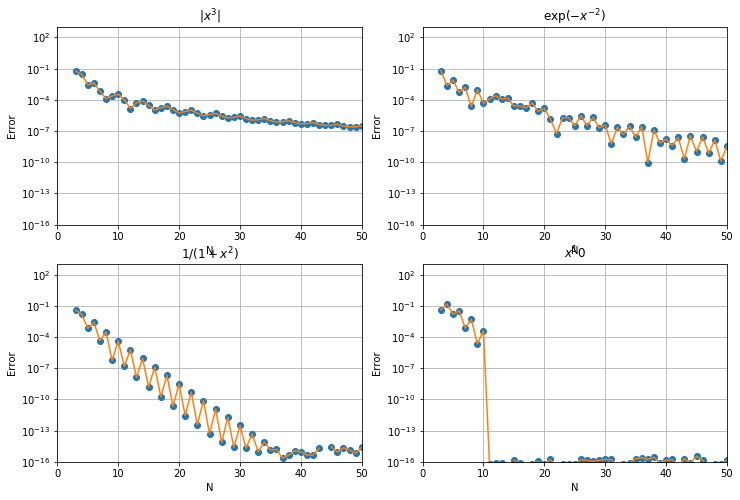

In [44]:
# Compare errors more carefully (program 30 in Trefethen)
#  Example directly uses Chebyshev differentiation matrix
import scipy.special

N_max = 50
error = numpy.zeros((4, N_max - 2))
N_range = numpy.arange(3, N_max + 1)
for (i, N) in enumerate(N_range):
    D_inv, x = cheb_diff(N)
    
    # 3rd derivative of bounded variation
    f = numpy.abs(x)**3
    f_int = 0.5
    error[0, i] = numpy.abs(numpy.dot(D_inv[0, :].transpose(), f) - f_int)
    # C_\infty function
    f = numpy.exp(-x**(-2))
    f_int = 2.0 * (numpy.exp(-1) + numpy.sqrt(numpy.pi) * (scipy.special.erf(1) - 1))
    error[1, i] = numpy.abs(numpy.dot(D_inv[0, :].transpose(), f) - f_int)
    # Analytic on [-1, 1]
    f = 1.0 / (1.0 + x**2)
    f_int = numpy.pi / 2.0
    error[2, i] = numpy.abs(numpy.dot(D_inv[0, :].transpose(), f) - f_int)
    # Polynomial
    f = x**10
    f_int = 2.0 / 11.0
    error[3, i] = numpy.abs(numpy.dot(D_inv[0, :].transpose(), f) - f_int)
    
# Plot errors
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
titles = ['$|x^3|$', '$\exp(-x^{-2})$', '$1 / (1 + x^2)$', '$x^10$']
for (i, title) in enumerate(titles):
    axes = fig.add_subplot(2, 2, i + 1)
    axes.semilogy(N_range, error[i, :], '.', markersize=12)
    axes.semilogy(N_range, error[i, :])
    axes.set_xlim((0, N_max))
    axes.set_ylim((1e-16, 1e3))
    axes.grid(True)
    axes.set_xlabel("N")
    axes.set_ylabel("Error")
    axes.set_title(title)

In [65]:
def clencurt(N):
    theta = numpy.pi * numpy.arange(N + 1) / N
    x = numpy.cos(theta)
    w = numpy.zeros(N + 1)
    ii = numpy.arange(1, N)
    v = numpy.ones(N - 1)
    if numpy.mod(N, 2) == 0:
        w[0] = 1.0 / (N**2 - 1.0)
        w[-1] = w[0]
        for k in range(N / 2):
            v -= 2.0 * numpy.cos(2.0 * k * theta[ii]) / (4.0 * k**2 - 1.0)
        v -= numpy.cos(N * theta[ii]) / (N**2 - 1.0)
    else:
        w[0] = 1.0 / N**2
        w[-1] = w[0]
        for k in range((N - 1) / 2 + 1):
            v -= 2.0 * numpy.cos(2.0 * k * theta[ii]) / (4.0 * k**2 - 1.0)

    w[ii] = 2.0 * v / N
    return w, x

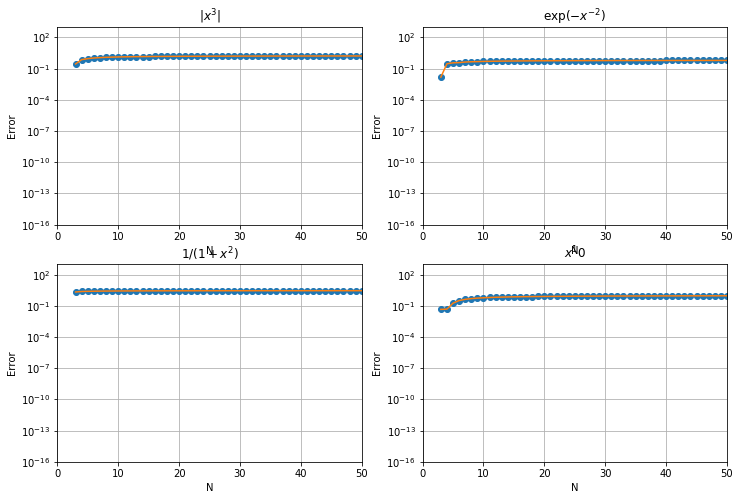

In [66]:
# Compare errors more carefully (program 30 in Trefethen)
#  Example using Clenshaw-Curtis quadrature weights
import scipy.special

N_max = 50
error = numpy.zeros((4, N_max - 2))
N_range = numpy.arange(3, N_max + 1)
for (i, N) in enumerate(N_range):
    w, x = clencurt(N)
    
    # 3rd derivative of bounded variation
    f = numpy.abs(x)**3
    f_int = 0.5
    error[0, i] = numpy.abs(numpy.dot(w, f) - f_int)
    # C_\infty function
    f = numpy.exp(-x**(-2))
    f_int = 2.0 * (numpy.exp(-1) + numpy.sqrt(numpy.pi) * (scipy.special.erf(1) - 1))
    error[1, i] = numpy.abs(numpy.dot(w, f) - f_int)
    # Analytic on [-1, 1]
    f = 1.0 / (1.0 + x**2)
    f_int = numpy.pi / 2.0
    error[2, i] = numpy.abs(numpy.dot(w, f) - f_int)
    # Polynomial
    f = x**10
    f_int = 2.0 / 11.0
    error[3, i] = numpy.abs(numpy.dot(w, f) - f_int)
    
# Plot errors
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
titles = ['$|x^3|$', '$\exp(-x^{-2})$', '$1 / (1 + x^2)$', '$x^10$']
for (i, title) in enumerate(titles):
    axes = fig.add_subplot(2, 2, i + 1)
    axes.semilogy(N_range, error[i, :], '.', markersize=12)
    axes.semilogy(N_range, error[i, :])
    axes.set_xlim((0, N_max))
    axes.set_ylim((1e-16, 1e3))
    axes.grid(True)
    axes.set_xlabel("N")
    axes.set_ylabel("Error")
    axes.set_title(title)

In [90]:
def gauss(N):
    beta = 0.5 / numpy.sqrt(1.0 - (2.0 * numpy.arange(1, N))**(-2))
    T = numpy.diag(beta, 1) + numpy.diag(beta, -1)
    x, V = numpy.linalg.eig(T)
    i = numpy.argsort(x)
    x = x[i]
    w = 2.0 * V[0, i]**2
    return w, x

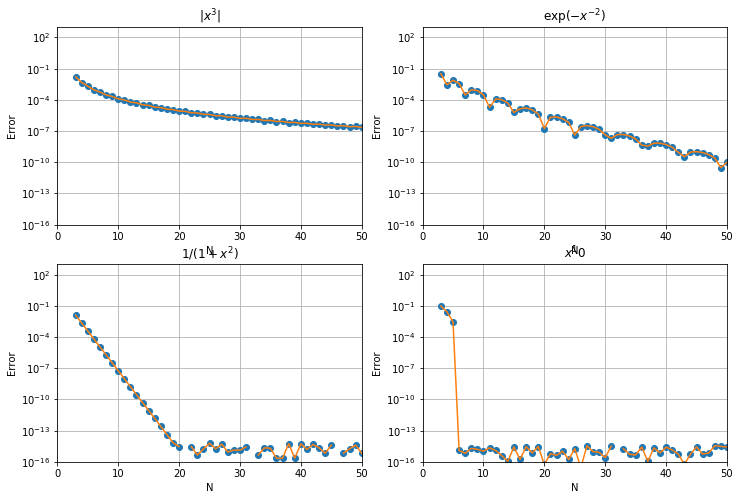

In [91]:
# Compare errors more carefully (program 30 in Trefethen)
#  Example using Gaussian quadrature (using Legendre points)
import scipy.special

N_max = 50
error = numpy.zeros((4, N_max - 2))
N_range = numpy.arange(3, N_max + 1)
for (i, N) in enumerate(N_range):
    w, x = gauss(N)
    
    # 3rd derivative of bounded variation
    f = numpy.abs(x)**3
    f_int = 0.5
    error[0, i] = numpy.abs(numpy.dot(w, f) - f_int)
    # C_\infty function
    f = numpy.exp(-x**(-2))
    f_int = 2.0 * (numpy.exp(-1) + numpy.sqrt(numpy.pi) * (scipy.special.erf(1) - 1))
    error[1, i] = numpy.abs(numpy.dot(w, f) - f_int)
    # Analytic on [-1, 1]
    f = 1.0 / (1.0 + x**2)
    f_int = numpy.pi / 2.0
    error[2, i] = numpy.abs(numpy.dot(w, f) - f_int)
    # Polynomial
    f = x**10
    f_int = 2.0 / 11.0
    error[3, i] = numpy.abs(numpy.dot(w, f) - f_int)
    
# Plot errors
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
titles = ['$|x^3|$', '$\exp(-x^{-2})$', '$1 / (1 + x^2)$', '$x^10$']
for (i, title) in enumerate(titles):
    axes = fig.add_subplot(2, 2, i + 1)
    axes.semilogy(N_range, error[i, :], '.', markersize=12)
    axes.semilogy(N_range, error[i, :])
    axes.set_xlim((0, N_max))
    axes.set_ylim((1e-16, 1e3))
    axes.grid(True)
    axes.set_xlabel("N")
    axes.set_ylabel("Error")
    axes.set_title(title)